In [86]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm #progress bar
import matplotlib.pyplot as plt
import seaborn as sns
from pivottablejs import pivot_ui

In [87]:
path = '/home/jewelle/data_bootcamp/LHL-final-project/'

#steam games dataset
df = pd.read_csv(path + 'steam-200k.csv', names=['userID','game','action','hours_played','other'])

In [88]:
df.head()

,userID,game,action,hours_played,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [89]:
df.shape

(200000, 5)

In [243]:
#metacritic ratings dataset
ratings = pd.read_csv(path + 'metacritic_games.csv')
ratings.head()

,game,platform,developer,genre,number_players,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
0,Portal 2,PC,Valve Software,Action,NaN,E10+,"Apr 18, 2011",51,1,0,1700,107,19,95,90
1,The Elder Scrolls V: Skyrim,PC,Bethesda Game Studios,Role-Playing,No Online Multiplayer,M,"Nov 10, 2011",32,0,0,1616,322,451,94,82
2,The Legend of Zelda: Ocarina of Time 3D,3DS,GREZZO,Miscellaneous,No Online Multiplayer,E10+,"Jun 19, 2011",84,1,0,283,20,5,94,90
3,Batman: Arkham City,PC,Rocksteady Studios,Action Adventure,NaN,T,"Nov 21, 2011",27,0,0,240,34,27,91,87
4,Super Mario 3D Land,3DS,Nintendo,Action,No Online Multiplayer,E,"Nov 13, 2011",81,1,0,251,39,11,90,84


In [244]:
ratings.shape

(5699, 15)

### Quick User Analysis

- identify user clusters
- purchased games do not necessarily have logged play hours
- identify top 10 in time/purchase

In [126]:
#check for missing values in df
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
other,0,0.0
hours_played,0,0.0
action,0,0.0
game,0,0.0
userID,0,0.0


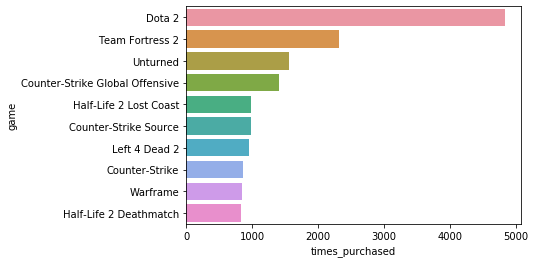

In [100]:
sns.set_palette("husl", 8)

df_purchase = df.loc[df['action'] == 'purchase']
purchased_times = df_purchase.groupby('game')['game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:10]

sns.barplot(y = 'game', 
            x = 'times_purchased', 
            data = purchased_times)

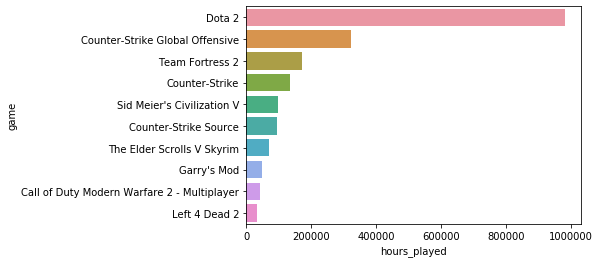

In [101]:
df_play = df.loc[df['action'] == 'play']
hours_played = df_play.groupby('game')['hours_played'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:10]

sns.barplot(y = 'game', 
            x = 'hours_played', 
            data = hours_played)

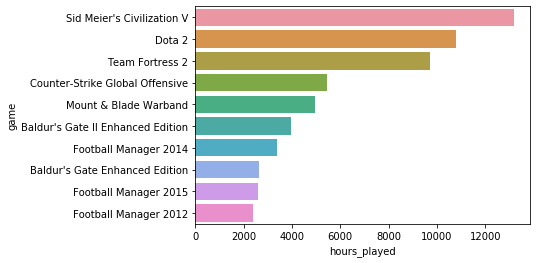

In [104]:
#most active users 
user_counts = df.groupby('userID')['hours_played'].agg(np.sum).sort_values(ascending=False)[0:10]
mask = df['userID'].isin(user_counts.index)
user_info = df.loc[mask].loc[df['action'] == 'play']
hours_played = user_info.groupby('game')['hours_played'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:10]

sns.barplot(y = 'game', x = 'hours_played', data = hours_played)

- kmeans clustering

In [106]:
purchased_df = df.loc[df['action'] == 'purchase']
played_df = df.loc[df['action'] == 'play']

In [107]:
user_counts = purchased_df.groupby('userID')['userID'].agg('count').sort_values(ascending=False)
hours_played = played_df.groupby('userID')['hours_played'].agg(np.sum).sort_values(ascending=False)

In [111]:
user_purchased_df = pd.DataFrame({'userID': user_counts.index, 'nb_purchased_games': user_counts.values})
user_played_df = pd.DataFrame({'userID': hours_played.index, 'hours_played': hours_played.values})

#merge
data = pd.merge(user_purchased_df, user_played_df, on='userID')
data.head()

,userID,nb_purchased_games,hours_played
0,62990992,1075,5724.8
1,33865373,783,2274.4
2,30246419,766,1219.7
3,58345543,667,1374.9
4,76892907,597,2731.3


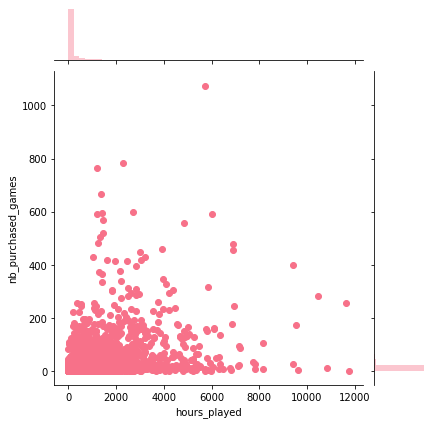

In [112]:
sns.jointplot(x='hours_played', 
              y='nb_purchased_games', 
              data=data)

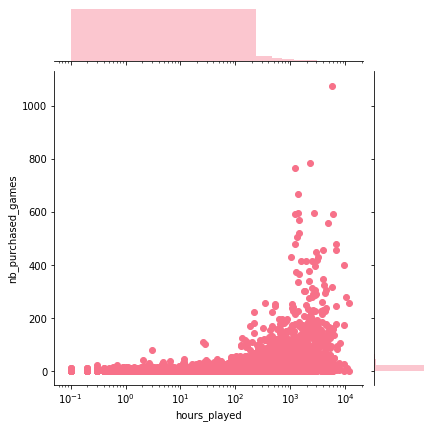

In [114]:
#scale data
g = sns.jointplot(x='hours_played', 
              y='nb_purchased_games', 
              data=data)
ax = g.ax_joint
ax.set_xscale('log')
g.ax_marg_x.set_xscale('log')
g

In [115]:
user_counts = played_df.groupby('userID')['userID'].agg('count').sort_values(ascending=False)
hours_played = played_df.groupby('userID')['hours_played'].agg(np.sum).sort_values(ascending=False)

user_played_df = pd.DataFrame({'userID': user_counts.index, 'nb_played_games': user_counts.values})
user_hours_played_df = pd.DataFrame({'userID': hours_played.index, 'hours_played': hours_played.values})

In [117]:
data = pd.merge(user_played_df, user_hours_played_df, on='userID')
data.head()

,userID,nb_played_games,hours_played
0,62990992,498,5724.8
1,11403772,314,6009.9
2,138941587,299,3011.2
3,47457723,298,4844.3
4,49893565,297,6891.9


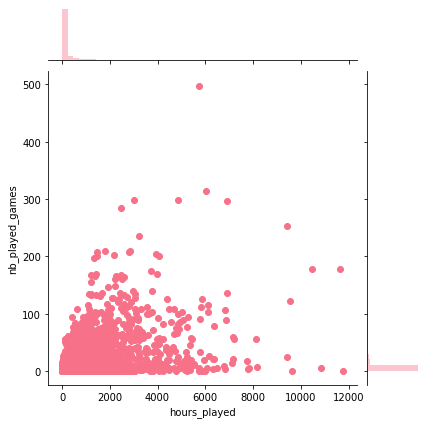

In [118]:
sns.jointplot(x='hours_played', 
              y='nb_played_games',
              data=data )

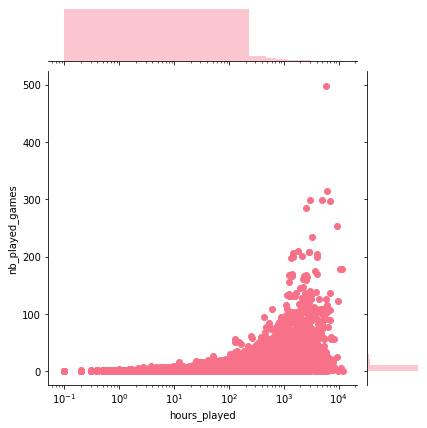

In [120]:
#scale data
g = sns.jointplot(x='hours_played', 
              y='nb_played_games', 
              data=data)
ax = g.ax_joint
ax.set_xscale('log')
g.ax_marg_x.set_xscale('log')
g

In [163]:
temp = pd.merge(user_purchased_df, data, on='userID')
temp = temp.copy()

In [164]:
temp.drop(['userID'], axis=1, inplace=True)
temp.head()

,nb_purchased_games,nb_played_games,hours_played
0,1075,498,5724.8
1,783,166,2274.4
2,766,135,1219.7
3,667,166,1374.9
4,597,98,2731.3


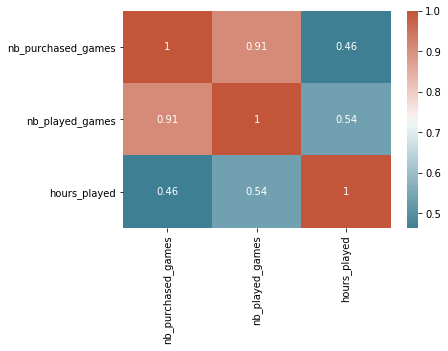

In [138]:
sns.heatmap(temp.corr(),
            annot=True,
            cmap=cmap)

- expected correlation between play and purchase.  Time spent in game does not seem to have strong correlation to either though.

In [199]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [216]:
data.drop(['userID'], axis=1, inplace=True)

In [223]:
scaler = StandardScaler()
train_data = scaler.fit_transform(data)

In [224]:
distortions = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters= k)
    km.fit(data)
    distortions.append(km.inertia_)

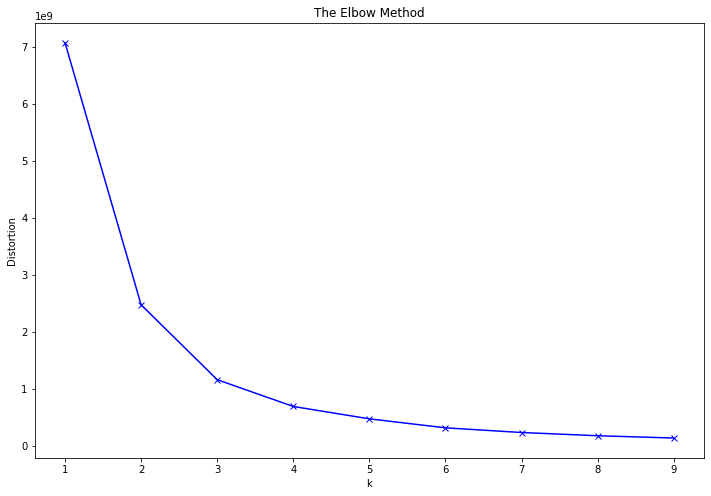

In [225]:
#Elbow Method
plt.figure(figsize=(12,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [226]:
#fit kmeans
km = KMeans(n_clusters= 3)
km.fit(data)

labels = km.labels_ # 0 to n_clusters-1

In [196]:
# Format results as a DataFrame
LABEL_COLOR_MAP = {0 : 'red',
                   1 : 'blue',
                   2 : 'green',
                   3 : 'orange',
                   
                  }

label_color = [LABEL_COLOR_MAP[l] for l in labels]

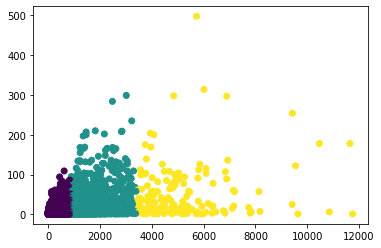

In [227]:
plt.figure('K-means')
plt.scatter(data['hours_played'],
            data['nb_played_games'], 
            c=km.labels_)
plt.show()

In [228]:
data.head()

,nb_played_games,hours_played,k_means
0,498,5724.8,3
1,314,6009.9,3
2,299,3011.2,1
3,298,4844.3,3
4,297,6891.9,3


### Market Analysis

In [229]:
#df has no missing values so get right into it

df.drop(['userID', 'other'], axis=1, inplace=True)

In [230]:
df = df[df['action'] == 'play'] #take only games with play hours logged
df.drop(['action'], axis=1, inplace=True)

In [231]:
#cumulative hours_played for each game

df = df.groupby('game').sum().reset_index()
df = df.sort_values('hours_played', ascending = False).reset_index(drop=True)

In [232]:
df.head()

,game,hours_played
0,Dota 2,981684.6
1,Counter-Strike Global Offensive,322771.6
2,Team Fortress 2,173673.3
3,Counter-Strike,134261.1
4,Sid Meier's Civilization V,99821.3


In [245]:
#dropping irrelevant columns. Steam = PC only

ratings = ratings[ratings['platform'] == 'PC']
ratings.drop(['platform'], axis=1, inplace=True)

In [246]:
ratings.drop(['developer', 'number_players', 'rating', 'release_date'], axis=1, inplace=True)

In [247]:
ratings.head()

,game,genre,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
0,Portal 2,Action,51,1,0,1700,107,19,95,90
1,The Elder Scrolls V: Skyrim,Role-Playing,32,0,0,1616,322,451,94,82
3,Batman: Arkham City,Action Adventure,27,0,0,240,34,27,91,87
5,Deus Ex: Human Revolution,Action,52,0,0,520,112,78,90,85
7,Total War: Shogun 2,Strategy,62,0,0,187,44,29,90,84


In [252]:
#check for missing values in ratings
total = ratings.isnull().sum().sort_values(ascending=False)
percent = (ratings.isnull().sum()/ratings.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
user_score,0,0.0
metascore,0,0.0
negative_users,0,0.0
neutral_users,0,0.0
positive_users,0,0.0


In [251]:
ratings.dropna(inplace=True)

In [253]:
#aggregate scores and binning

ratings['neutral_critics'] = ratings['neutral_critics']*0.5
ratings['negative_critics'] = ratings['negative_critics']*(-1)
ratings['neutral_users'] = ratings['neutral_users']*0.5
ratings['negative_users'] = ratings['negative_users']*(-1)
ratings['score'] = ratings['positive_critics'] + ratings['neutral_critics'] + ratings['negative_critics'] + ratings['neutral_users'] + ratings['negative_users'] + ratings['positive_users']

In [254]:
ratings = ratings[['game', 'genre', 'metascore', 'user_score', 'score']]
ratings = ratings.sort_values('score',ascending=False).reset_index(drop=True)

ratings.head()

,game,genre,metascore,user_score,score
0,Portal 2,Action,95,90,1786.0
1,The Elder Scrolls V: Skyrim,Role-Playing,94,82,1358.0
2,The Witcher 3: Wild Hunt,Action RPG,93,94,1277.0
3,The Witcher 2: Assassins of Kings,Role-Playing,88,85,1214.5
4,BioShock Infinite,Action,94,86,1174.5


In [255]:
#merge
final = pd.merge(df, ratings, how='inner', left_on='game', right_on='game')
final.head()

,game,hours_played,genre,metascore,user_score,score
0,Dota 2,981684.6,General,90,65,201.5
1,Football Manager 2013,32308.6,Sports,86,68,41.0
2,Football Manager 2012,30845.8,Sports,84,79,64.5
3,Football Manager 2014,30574.8,Sports,85,56,7.5
4,Terraria,29951.8,Action,83,86,522.5


- can look at popularity by both time spent playing game and ratings

In [256]:
by_time = final.sort_values('hours_played',ascending=False) #sort by most time played
by_rt = final.sort_values('score', ascending=False) #sort by highest agg score

In [257]:
by_time

,game,hours_played,genre,metascore,user_score,score
0,Dota 2,981684.6,General,90,65,201.5
1,Football Manager 2013,32308.6,Sports,86,68,41.0
2,Football Manager 2012,30845.8,Sports,84,79,64.5
3,Football Manager 2014,30574.8,Sports,85,56,7.5
4,Terraria,29951.8,Action,83,86,522.5
...,...,...,...,...,...,...
538,Who's That Flying?!,0.2,Action,76,67,7.5
539,Gateways,0.2,Action,72,77,7.0
540,Formula Fusion,0.1,Racing,58,75,8.0
541,BlazeRush,0.1,Driving,66,82,10.0


In [258]:
by_rt

,game,hours_played,genre,metascore,user_score,score
15,Portal 2,9117.1,Action,95,90,1786.0
28,BioShock Infinite,3689.1,Action,94,86,1174.5
118,Undertale,444.6,Role-Playing,92,83,786.0
32,Tomb Raider,3184.3,Action Adventure,86,85,563.0
4,Terraria,29951.8,Action,83,86,522.5
...,...,...,...,...,...,...
70,ArcheAge,1109.7,Role-Playing,80,37,-164.0
12,Fallout 4,10762.8,General,84,55,-215.5
148,X Rebirth,280.0,Simulation,33,32,-365.0
133,Dragon Age II,372.8,Role-Playing,82,45,-466.0


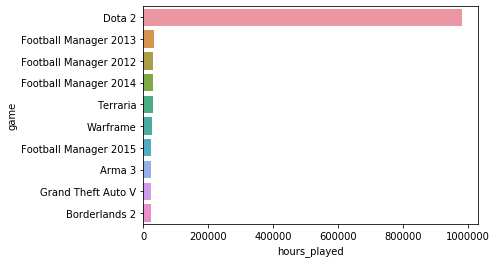

In [259]:
top_by_time = by_time[:10]

sns.barplot(y = 'game',
            x = 'hours_played',
            data = top_by_time)

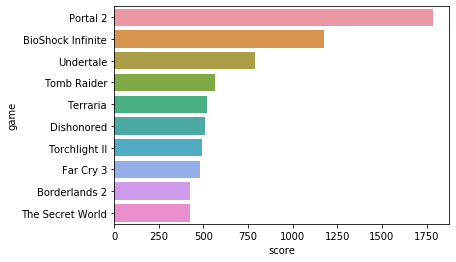

In [260]:
top_by_rt = by_rt[:10]

sns.barplot(y = 'game',
            x = 'score',
            data = top_by_rt)

- cursory glance at both tables don't show much correlation between ratings and hours played
- let's look at a heatmap to see if that's true

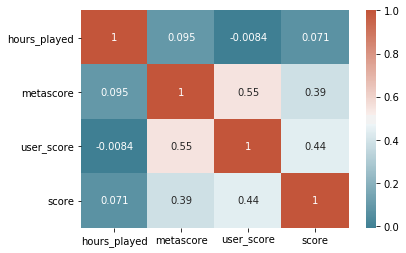

In [266]:
corr = final.corr()

# color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]

sns.heatmap(corr, 
            cmap=cmap,
            annot = True,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

In [276]:
X = final[['hours_played']].values

minmax = MinMaxScaler()
x_scaled = minmax.fit_transform(X)

final['hours_scaled'] = pd.DataFrame(x_scaled)

In [278]:
X = final[['score']].values

x_scaled = minmax.fit_transform(X)

final['score_scaled'] = pd.DataFrame(x_scaled)

In [279]:
final.head()

,game,hours_played,genre,metascore,user_score,score,hours_scaled,score_scaled
0,Dota 2,981684.6,General,90,65,201.5,1.000000,0.362374
1,Football Manager 2013,32308.6,Sports,86,68,41.0,0.032911,0.297787
2,Football Manager 2012,30845.8,Sports,84,79,64.5,0.031421,0.307243
3,Football Manager 2014,30574.8,Sports,85,56,7.5,0.031145,0.284306
4,Terraria,29951.8,Action,83,86,522.5,0.030511,0.491549


In [293]:
def normalize(lst):
    norm = []
    mx = max(lst)
    mn = min(lst)
    for i in lst:
        norm.append( ((i - mn) / (mx - mn)) * 2 )
    return norm

In [294]:
top_by_time['hours_scaled'] = normalize(top_by_time['hours_played'].tolist())
top_by_time['score_scaled'] = normalize(top_by_time['score'].tolist())
top_by_time.reset_index(drop=True,inplace=True)
top_by_time

,game,hours_played,genre,metascore,user_score,score,hours_scaled,score_scaled
0,Dota 2,981684.6,General,90,65,201.5,2.000000,0.753398
1,Football Manager 2013,32308.6,Sports,86,68,41.0,0.020105,0.130097
2,Football Manager 2012,30845.8,Sports,84,79,64.5,0.017055,0.221359
3,Football Manager 2014,30574.8,Sports,85,56,7.5,0.016490,0.000000
4,Terraria,29951.8,Action,83,86,522.5,0.015190,2.000000
5,Warframe,27074.6,Action,71,84,269.0,0.009190,1.015534
6,Football Manager 2015,24283.1,Sports,80,61,26.5,0.003368,0.073786
7,Arma 3,24055.7,Simulation,74,75,120.5,0.002894,0.438835
8,Grand Theft Auto V,22956.7,Modern,96,77,267.5,0.000602,1.009709
9,Borderlands 2,22667.9,Action,89,82,424.5,0.000000,1.619417


In [295]:
top_by_rt['hours_scaled'] = normalize(top_by_rt['hours_played'].tolist())
top_by_rt['score_scaled'] = normalize(top_by_rt['score'].tolist())
top_by_rt.reset_index(drop=True,inplace=True)
top_by_rt

,game,hours_played,genre,metascore,user_score,score,hours_scaled,score_scaled
0,Portal 2,9117.1,Action,95,90,1786.0,0.591922,2.000000
1,BioShock Infinite,3689.1,Action,94,86,1174.5,0.225079,1.102056
2,Undertale,444.6,Role-Playing,92,83,786.0,0.005805,0.531571
3,Tomb Raider,3184.3,Action Adventure,86,85,563.0,0.190963,0.204112
4,Terraria,29951.8,Action,83,86,522.5,2.000000,0.144640
5,Dishonored,2842.2,Action Adventure,91,84,510.5,0.167843,0.127019
6,Torchlight II,6891.9,Role-Playing,88,85,491.0,0.441535,0.098385
7,Far Cry 3,5076.0,Action,88,83,478.5,0.318811,0.080029
8,Borderlands 2,22667.9,Action,89,82,424.5,1.507730,0.000734
9,The Secret World,358.7,Role-Playing,74,83,424.0,0.000000,0.000000


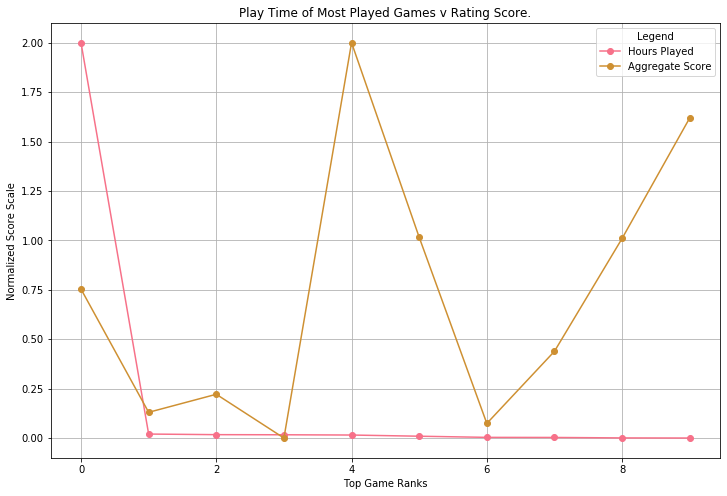

In [297]:
#top 10 most played games
fig1 = plt.figure(figsize=(12, 8))
plt.plot(top_by_time['hours_scaled'],'-o',label='Hours Played')
plt.plot(top_by_time['score_scaled'],'-o',label='Aggregate Score')
plt.legend(title='Legend')

plt.grid()
plt.title('Play Time of Most Played Games v Rating Score.');
plt.xlabel('Top Game Ranks');
plt.ylabel('Normalized Score Scale');

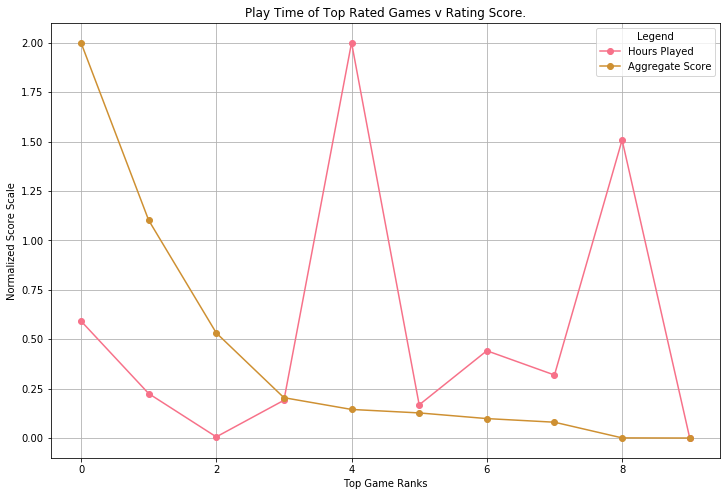

In [298]:
#top 10 highest-rated games
fig1 = plt.figure(figsize=(12, 8))
plt.plot(top_by_rt['hours_scaled'],'-o',label='Hours Played')
plt.plot(top_by_rt['score_scaled'],'-o',label='Aggregate Score')
plt.legend(title='Legend')

plt.grid()
plt.title('Play Time of Top Rated Games v Rating Score.');
plt.xlabel('Top Game Ranks');
plt.ylabel('Normalized Score Scale');